In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy
import time
import random
from scipy import stats
from scipy.stats import mode
import seaborn as sns
import warnings
from collections import defaultdict
warnings.filterwarnings("ignore")
from scipy.stats import chisquare

## Annotate pairs with the snp information

In [7]:
snps = pd.read_csv("output/03.annotation/snps_with_all_annotation.csv", index_col=0)
snps_columns_to_keep = [
    "pos", 
    "gene_name", 
    "gene_id", 
    "is_lineage",
    "in_antigen_epitope",
    "in_antigen_protein", 
    "in_known_ABR_position",
    "known_drug", 
    "in_possible_ABR_gene", 
    "possible_drug"

]
snps

,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name,is_lineage,in_antigen_protein,AA_change,aa_position,in_antigen_epitope,in_known_ABR_position,known_drug,in_possible_ABR_gene,possible_drug,in_essential_gene_minato
0,290,G,"['C', 'T']",Rv0001,289.0,Essential,dnaA,False,False,G97A,97,False,False,NaN,False,NaN,True
2,490,G,['A'],Rv0001,489.0,Essential,dnaA,False,False,G164S,164,False,False,NaN,False,NaN,True
3,573,G,"['C', 'T']",Rv0001,572.0,Essential,dnaA,False,False,L191F,191,False,False,NaN,False,NaN,True
5,696,G,"['A', 'C', 'T']",Rv0001,695.0,Essential,dnaA,False,False,M232I,232,False,False,NaN,False,NaN,True
8,697,C,['T'],Rv0001,696.0,Essential,dnaA,False,False,R233W,233,False,False,NaN,False,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7252,4408156,A,"['C', 'G']",Rv3919c,628.0,Antibiotic Resistance,gid,True,False,L16R,16,False,False,NaN,True,STM,False
7254,4408168,A,"['C', 'G']",Rv3919c,640.0,Antibiotic Resistance,gid,False,False,F12C,12,False,False,NaN,True,STM,False
7256,4408185,G,"['A', 'C']",Rv3919c,657.0,Antibiotic Resistance,gid,False,False,P6P,6,False,False,NaN,True,STM,False
7258,4408806,G,['A'],Rv3920c,472.0,Non-Essential,Rv3920c,False,False,A31V,31,False,False,NaN,False,NaN,False


In [8]:
!mkdir output/04A.pair_annotation

mkdir: cannot create directory ‘output/04A.pair_annotation’: File exists


In [9]:

# Add gene and lineage  annotation to the results
results = pd.read_csv("output/02A.comutation_pvalues/results_file_allpairs.csv")
results = results.merge(snps[snps_columns_to_keep], left_on="position_i", right_on="pos")
results = results.merge(snps[snps_columns_to_keep], left_on="position_j", right_on="pos", suffixes=["_i", "_j"])
results.columns

print("total pairs", len(results))
print("total non-lineage pairs", len(results.query("not is_lineage_i and not is_lineage_j")))

results = results.query("not is_lineage_i and not is_lineage_j")

results = results[[
   'position_i', 'gene_name_i','position_j', 'gene_name_j',
    'n_mutations_i',
   'n_mutations_j', 'n_branches_with_i', 'n_branches_with_j',
   'n_muts_i_on_branch_j', 'n_muts_j_on_branch_i', 'n_muts_same_branch',
   'n_branch_with_i_no_j', 'n_branch_with_j_no_i', 'n_branch_i_and_j',
   'pval_beta_i_on_j', 'BH_critical_value', 'pval_beta_i_on_j_BH_sig',
    'is_lineage_i','is_lineage_j',
    'gene_id_i', 'gene_id_j', 
    "in_antigen_epitope_i",
    "in_antigen_protein_i", 
    "in_known_ABR_position_i",
    "known_drug_i", 
    "in_possible_ABR_gene_i", 
    "possible_drug_i",
    "in_antigen_epitope_j",
    "in_antigen_protein_j", 
    "in_known_ABR_position_j",
    "known_drug_j", 
    "in_possible_ABR_gene_j", 
    "possible_drug_j"
]]
results.to_csv("output/04A.pair_annotation/results_allpairs_annotated.csv")

print("total_significant", len(results.query("pval_beta_i_on_j_BH_sig")))
results.query("pval_beta_i_on_j_BH_sig").to_csv("output/04A.pair_annotation/results_significant_annotated.csv")

total pairs 1768192
total non-lineage pairs 1210880
total_significant 25626


In [10]:
25626/1210880

0.021163121035940802

## Overall analysis of hits

In [11]:
def annotate(top_hits):
    def _separate_hits(logic_columns, current_df):
        is_hit = np.sum(current_df[logic_columns].values, axis=1) > 0

        hit_df = current_df.iloc[is_hit, :]
        current_df = current_df.iloc[~is_hit, :]
        return hit_df, current_df

    # start with the df of top hits. Get just the known antibiotic hits
    top_hits["annotation"] = 'other'
    logic_columns = ["in_known_ABR_position_i", "in_known_ABR_position_j"]

    antibiotic_hits, current_df = _separate_hits(logic_columns, top_hits)

    # if both are antibiotic, annotate that
    antibiotic_hits.loc[
        np.logical_and(
            antibiotic_hits.in_known_ABR_position_i.values, 
            antibiotic_hits.in_known_ABR_position_j.values
        ), 
        "annotation"
    ] = "between_known_AB"

    # if just one, annotate that
    antibiotic_hits.loc[
        np.logical_and(
            antibiotic_hits.in_known_ABR_position_i.values, 
            ~antibiotic_hits.in_known_ABR_position_j.values
        ), 
        "annotation"
    ] = "known_AB_second"

    antibiotic_hits.loc[
        np.logical_and(
            ~antibiotic_hits.in_known_ABR_position_i.values, 
            antibiotic_hits.in_known_ABR_position_j.values
        ), 
        "annotation"
    ] = "known_AB_first"

    # Then get the antigen proteins
    logic_columns = ['in_antigen_protein_i','in_antigen_protein_j',]

    antigen_hits, current_df = _separate_hits(logic_columns, current_df)

    # if just one, annotate that
    antigen_hits.loc[
        np.logical_or(
            antigen_hits.in_antigen_protein_i.values, 
            antigen_hits.in_antigen_protein_j.values
        ), 
        "annotation"
    ] = "one_antigen"

    antigen_hits.loc[
        np.logical_and(
            antigen_hits.in_antigen_protein_i.values, 
            antigen_hits.in_antigen_protein_j.values
        ), 
        "annotation"
    ] = "both_antigen"

    # then get the maybe antibiotic hits
    logic_columns = ["in_possible_ABR_gene_i", "in_possible_ABR_gene_j"]

    maybe_antibiotic_hits, current_df = _separate_hits(logic_columns, current_df)

    # if both are antibiotic, annotate that
    maybe_antibiotic_hits.loc[
        np.logical_and(
            maybe_antibiotic_hits.in_possible_ABR_gene_i.values, 
            maybe_antibiotic_hits.in_possible_ABR_gene_j.values
        ), 
        "annotation"
    ] = "between_maybe_AB"

    # if just one, annotate that
    maybe_antibiotic_hits.loc[
        np.logical_and(
            maybe_antibiotic_hits.in_possible_ABR_gene_i.values, 
            ~maybe_antibiotic_hits.in_possible_ABR_gene_j.values
        ), 
        "annotation"
    ] = "maybe_AB_second"

    maybe_antibiotic_hits.loc[
        np.logical_and(
            ~maybe_antibiotic_hits.in_possible_ABR_gene_i.values, 
            maybe_antibiotic_hits.in_possible_ABR_gene_j.values
        ), 
        "annotation"
    ] = "maybe_AB_first"

    return pd.concat([antigen_hits, antibiotic_hits, maybe_antibiotic_hits, current_df])

In [12]:

top_hits = pd.read_csv("output/04A.pair_annotation/results_significant_annotated.csv", index_col=0)
top_hits = annotate(top_hits)

In [13]:

logic_columns = ['in_antigen_epitope_i', 'in_antigen_protein_i',
   'in_known_ABR_position_i', 'in_possible_ABR_gene_i',
    'in_antigen_epitope_j', 'in_antigen_protein_j',
   'in_known_ABR_position_j',  'in_possible_ABR_gene_j']

to_analyze = np.sum(top_hits[logic_columns].values, axis =1) > 0

other_hits = top_hits.iloc[~to_analyze, :]
current_hits = top_hits.iloc[to_analyze, :]

print(to_analyze.shape, len(other_hits), len(current_hits))

(25626,) 9632 15994


In [14]:
top_hits.sort_values("pval_beta_i_on_j")[[
    "position_i",  "gene_name_i", "position_j", "gene_name_j", 
    "n_mutations_i", "n_mutations_j", "n_branches_with_j", "n_muts_i_on_branch_j","pval_beta_i_on_j", "annotation"
]].head(20)

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_j,n_muts_i_on_branch_j,pval_beta_i_on_j,annotation
4091,781687,rpsL,75233,None,783,43,24274,569,8.499085e-205,known_AB_second
25875,781687,rpsL,1722228,pks5,783,8,16173,465,1.287732e-185,known_AB_second
36464,781687,rpsL,4060588,esxW,783,116,16379,465,5.586984e-182,known_AB_second
43711,781687,rpsL,3446699,Rv3081,783,81,16441,465,7.175850e-181,known_AB_second
50972,781687,rpsL,2867575,lppB,783,25,16157,460,3.753997e-178,known_AB_second
54564,781687,rpsL,2626018,esxO,783,105,17461,468,3.398670e-171,known_AB_second
58363,781687,rpsL,3894732,PPE60,783,59,17091,466,3.635548e-171,known_AB_second
62119,781687,rpsL,1341040,esxL,783,25,43024,685,3.566276e-165,known_AB_second
66741,781687,rpsL,1287112,None,783,7,42982,684,3.728031e-163,known_AB_second
80578,781687,rpsL,340132,PPE3,783,134,21827,512,1.419830e-160,known_AB_second


In [15]:
top_hits.sort_values("n_muts_i_on_branch_j", ascending=False)[[
    "position_i",  "gene_name_i", "position_j", "gene_name_j", 
    "n_mutations_i", "n_mutations_j", "n_branches_with_j", "n_muts_i_on_branch_j","pval_beta_i_on_j", "annotation"
]].head(20)

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_j,n_muts_i_on_branch_j,pval_beta_i_on_j,annotation
122985,761155,rpoB,1341044,esxL,1487,8,53351,1315,7.957268e-42,known_AB_second
62270,2155168,katG,1341040,esxL,1811,25,43024,1261,4.998956e-06,known_AB_second
66893,2155168,katG,1287112,None,1811,7,42982,1259,7.231456e-06,known_AB_second
113701,761155,rpoB,2626108,esxO,1487,39,45234,1155,5.885287e-35,known_AB_second
66779,761155,rpoB,1287112,None,1487,7,42982,1067,5.064629e-13,known_AB_second
62157,761155,rpoB,1341040,esxL,1487,25,43024,1067,1.069903e-12,known_AB_second
109416,2155168,katG,1276588,Rv1148c,1811,239,27473,807,4.653724e-05,known_AB_second
4228,2155168,katG,75233,None,1811,43,24274,771,1.090171e-14,known_AB_second
122957,4247429,embB,1341044,esxL,819,8,53351,751,1.709515e-67,known_AB_second
113,2155168,katG,454333,Rv0376c,1811,5,22992,745,1.057896e-18,known_AB_second


In [16]:
print(top_hits.groupby("annotation").size())

annotation
between_known_AB      129
between_maybe_AB       53
both_antigen         1570
known_AB_first        635
known_AB_second      2159
maybe_AB_first        295
maybe_AB_second      1021
one_antigen         10132
other                9632
dtype: int64


mkdir: cannot create directory ‘figures’: File exists


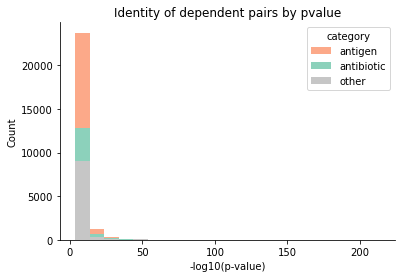

In [17]:
!mkdir figures
# Create beautiful perfect color palette
pal = sns.color_palette("Set2")
figure = plt.figure()
ax = figure.gca()
top_hits["log_pval"] = -np.log10(top_hits.pval_beta_i_on_j)
for_display = top_hits
for_display["category"] = for_display.annotation
for_display["category"] = ["antibiotic" if x in ["known_AB_second", "between_known_AB", "known_AB_first", "maybe_AB_second", "between_maybe_AB", "maybe_AB_first"] else x for x in for_display.category]
for_display["category"] = ["antigen" if x in ["one_antigen", "both_antigen"] else x for x in for_display.category]

sns.histplot(
    data = for_display, x="log_pval", multiple='stack',
    hue="category", 
    binwidth=10, 
    log_scale=[False,False], 
    palette = {"antibiotic":pal[0],
               "antigen":pal[1],
               "other":pal[7]
              },
    linewidth=0
)
ax.set_xlabel("-log10(p-value)")
ax.set_title("Identity of dependent pairs by pvalue")
sns.despine()
#plt.savefig("figures/identity_by_occurrence.pdf")

mkdir: cannot create directory ‘figures’: File exists


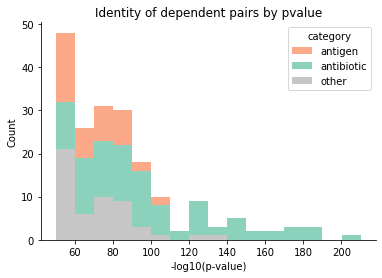

In [18]:
!mkdir figures
# Create beautiful perfect color palette
pal = sns.color_palette("Set2")
figure = plt.figure()
ax = figure.gca()
#top_hits["log_pval"] = -np.log10(top_hits.pval_beta_i_on_j)

for_display = for_display.query("log_pval > 50")

sns.histplot(
    data = for_display, x="log_pval", multiple='stack',
    hue="category", 
    binwidth=10, 
    log_scale=[False,False], 
    palette = {"antibiotic":pal[0],
               "antigen":pal[1],
               "other":pal[7]
              },
    linewidth=0
)
ax.set_xlabel("-log10(p-value)")
ax.set_title("Identity of dependent pairs by pvalue")
# ax.set_xlim([20,250])
# ax.set_ylim([0,3000])
sns.despine()
#plt.savefig("figures/identity_by_occurrence.pdf")

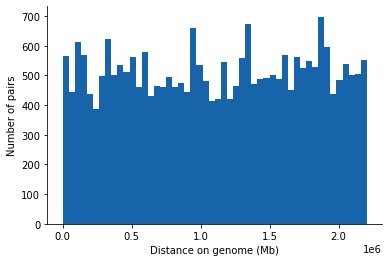

In [19]:
def dist(p1,p2):
    
    total_nucleotides = 4411532    

    max_dist = int(total_nucleotides / 2)
    # accounts for circularization of genome
    d1 = np.abs(p1 - p2)
    
    #print(i,j,d1)
    if d1 > max_dist:
        i,j=sorted([p1,p2])
        #print("too_far!", d1)
        i = i + total_nucleotides
        d1 = i-j
        #print("new distance", d1)
        
    return d1

pal = sns.color_palette("Blues",4)

for_display = top_hits
for_display["mutation_distance"] = [dist(x,y) for x,y in zip(for_display.position_i, for_display.position_j)]
plt.hist(for_display.mutation_distance, 50, color=pal[3])
plt.xlabel("Distance on genome (Mb)")
plt.ylabel("Number of pairs")
sns.despine()
plt.savefig("figures/sequential_mutations_distance.pdf")

In [20]:
top_hits.to_csv("output/04A.pair_annotation/results_significant_annotated_categories.csv")

### Enrichment calculations

In [21]:
all_hits = pd.read_csv("output/04A.pair_annotation/results_allpairs_annotated.csv")
all_hits = annotate(all_hits)

In [22]:
all_hits.to_csv("output/04A.pair_annotation/results_allpairs_annotation_withcategories.csv")
print(all_hits.groupby("annotation").size())

annotation
between_known_AB      6246
between_maybe_AB      3242
both_antigen         83420
known_AB_first       79837
known_AB_second      79837
maybe_AB_first       46731
maybe_AB_second      46731
one_antigen         460492
other               404344
dtype: int64


#### Question 1: are the overlapping hits an enrichment in some way based on our expectation from the distribution of SNPs?

In [23]:
## Actual numbers: 162 epitopes, 804 antigens, 250 known resistance, 813 possible resistance, 2747 no category
total_snps = 4776

p_epitope = 162/total_snps
p_antigen = 804/total_snps
p_known_R = 250/total_snps
p_possible_R = (813-250)/total_snps
p_other = (total_snps - 804 - 813)/total_snps

# bang this out
e_between_known_AB = p_known_R * p_known_R
e_between_maybe_AB = p_possible_R * p_possible_R
e_both_antigen = p_antigen * p_antigen

e_known_AB_first = p_known_R * (1-p_known_R)
e_known_AB_second = p_known_R * (1-p_known_R)

e_maybe_AB_first = p_possible_R * (p_other)
e_maybe_AB_second = p_possible_R * (p_other)

e_one_antigen = 2 * p_antigen * (p_other + p_possible_R)
e_other = p_other * p_other


top_hits_values = all_hits.groupby("annotation").size()
labels = all_hits.groupby("annotation").size().index

all_hits_expectation = np.array([e_between_known_AB, e_between_maybe_AB, e_both_antigen, e_known_AB_first, 
                        e_known_AB_second, e_maybe_AB_first, e_maybe_AB_second, e_one_antigen, e_other]) * len(all_hits)

## Table of nice results

result_df = pd.DataFrame({
                          "actual_pair_freq": top_hits_values, 
                          "expected_pair_freq": all_hits_expectation})
print(chisquare(top_hits_values,  f_exp=all_hits_expectation))

print(result_df)
result_df1 = result_df
result_df1["chi_square"] = chisquare(top_hits_values,  f_exp=all_hits_expectation)[0]
result_df1["p_value"] = chisquare(top_hits_values,  f_exp=all_hits_expectation)[1]
result_df1.to_csv("output/04A.chisquare_all_pairs_vs_expected.csv")

Power_divergenceResult(statistic=238850.05747434398, pvalue=0.0)
                  actual_pair_freq  expected_pair_freq
annotation                                            
between_known_AB              6246         3317.817451
between_maybe_AB              3242        16826.324476
both_antigen                 83420        34315.044570
known_AB_first               79837        60065.767138
known_AB_second              79837        60065.767138
maybe_AB_first               46731        94412.715841
maybe_AB_second              46731        94412.715841
one_antigen                 460492       317712.925094
other                       404344       529750.922451


In [24]:
result_df1["actual_percent"] = result_df1.actual_pair_freq /  result_df1.actual_pair_freq.sum()
result_df1["expected_percent"] = result_df1.expected_pair_freq /  result_df1.expected_pair_freq.sum()
result_df1

,actual_pair_freq,expected_pair_freq,chi_square,p_value,actual_percent,expected_percent
annotation,,,,,,
between_known_AB,6246,3317.817451,238850.057474,0.0,0.005158,0.002740
between_maybe_AB,3242,16826.324476,238850.057474,0.0,0.002677,0.013896
both_antigen,83420,34315.044570,238850.057474,0.0,0.068892,0.028339
known_AB_first,79837,60065.767138,238850.057474,0.0,0.065933,0.049605
known_AB_second,79837,60065.767138,238850.057474,0.0,0.065933,0.049605
maybe_AB_first,46731,94412.715841,238850.057474,0.0,0.038593,0.077970
maybe_AB_second,46731,94412.715841,238850.057474,0.0,0.038593,0.077970
one_antigen,460492,317712.925094,238850.057474,0.0,0.380295,0.262382
other,404344,529750.922451,238850.057474,0.0,0.333926,0.437493


In [25]:
# actual vs expected epitopes
.065497 + .371980,0.028339+ 0.262382

(0.437477, 0.290721)

In [26]:
# Actual vs expected antibiotic resistance
0.004901 + 0.064623 + 0.064623, 0.002740 + 0.049605 + 0.049605

(0.13414700000000002, 0.10195000000000001)

#### Question 2: are the top hits enriched relative to all the cooccurences?

In [27]:


top_hits_values = top_hits.groupby("annotation").size().values
all_hits_expectation = all_hits.groupby("annotation").size().values / len(all_hits) * len(top_hits)

print(top_hits_values, all_hits_expectation)
print(chisquare(top_hits_values,  f_exp=all_hits_expectation))

## Table of nice results

result_df = pd.DataFrame({ 
    "category": top_hits.groupby("annotation").size().index,
    "actual_hit_freq": top_hits_values, 
    "expected_hit_freq": all_hits_expectation})

print(result_df)
result_df2 = result_df

[  129    53  1570   635  2159   295  1021 10132  9632] [ 132.18485399   68.6108384  1765.42755682 1689.60009415 1689.60009415
  988.97380913  988.97380913 9745.44793208 8557.18101216]
Power_divergenceResult(statistic=1452.261101513723, pvalue=2.832677007224131e-308)
           category  actual_hit_freq  expected_hit_freq
0  between_known_AB              129         132.184854
1  between_maybe_AB               53          68.610838
2      both_antigen             1570        1765.427557
3    known_AB_first              635        1689.600094
4   known_AB_second             2159        1689.600094
5    maybe_AB_first              295         988.973809
6   maybe_AB_second             1021         988.973809
7       one_antigen            10132        9745.447932
8             other             9632        8557.181012


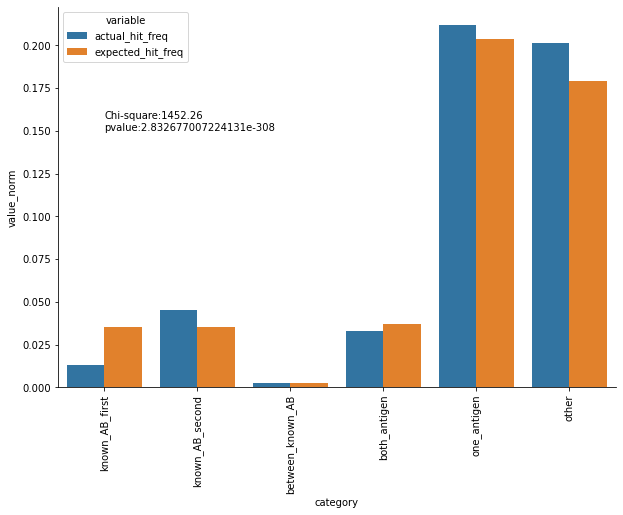

In [28]:
## Make a bar chart of actual vs. observations

# sort the result dataframe in desired order

cats_to_remove = ["between_maybe_AB", "maybe_AB_first", "maybe_AB_second"]
result_df = result_df.query("category not in @cats_to_remove")

desired_order = ["known_AB_first", "known_AB_second", "between_known_AB", "both_antigen", "one_antigen", "other"]
sorter = [desired_order.index(x) for x in result_df.category]
result_df = result_df.iloc[sorter, :]

to_plot = result_df.melt(["category"])
#to_plot["value"] = [np.log10(x) for x in to_plot.value]

# normalize the result dataframe
to_plot["value_norm"] = to_plot.value / to_plot.value.sum()

fig= plt.figure(figsize=(10,7))
ax = fig.gca()

sns.barplot(data = to_plot, x='category', y = 'value_norm', hue='variable', 
            #palette={"actual_hit_freq":pal[2], "expected_hit_freq":pal[7]}
           )
plt.xticks(rotation=90)
cs = chisquare(top_hits_values,  f_exp=all_hits_expectation)

ax.text(x = 0, y=.15, s=f"Chi-square:{np.round(cs.statistic,2)}\npvalue:{cs.pvalue}")
sns.despine()



## Question 3: are the highest pvalue hits enriched wrt the freq of all pairs?

In [29]:
top_hits_values = top_hits.sort_values("pval_beta_i_on_j").iloc[0:100].groupby("annotation").size().values
all_hits_expectation = top_hits.groupby("annotation").size().values / len(top_hits) * 100

top_hits_values = [0,0,2,0,69,0,0,12,17]
print(chisquare(top_hits_values,  f_exp=all_hits_expectation))

result_df = pd.DataFrame({ 
    "category": top_hits.groupby("annotation").size().index,
    "actual_top_hit_freq": top_hits_values, 
    "expected_top_hit_freq": all_hits_expectation})

print(result_df)
result_df3 = result_df

Power_divergenceResult(statistic=477.085195620747, pvalue=5.78476679456767e-98)
           category  actual_top_hit_freq  expected_top_hit_freq
0  between_known_AB                    0               0.503395
1  between_maybe_AB                    0               0.206821
2      both_antigen                    2               6.126590
3    known_AB_first                    0               2.477952
4   known_AB_second                   69               8.425037
5    maybe_AB_first                    0               1.151175
6   maybe_AB_second                    0               3.984235
7       one_antigen                   12              39.537969
8             other                   17              37.586826


In [30]:
## What are the top hits in the "other" category? 
top_hits.query("annotation=='other'").sort_values("pval_beta_i_on_j").head(20)

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_branches_with_j,n_muts_i_on_branch_j,n_muts_j_on_branch_i,...,in_antigen_epitope_j,in_antigen_protein_j,in_known_ABR_position_j,known_drug_j,in_possible_ABR_gene_j,possible_drug_j,annotation,log_pval,category,mutation_distance
1110385,2829918,None,2339255,Rv2082,74,43,1118,20062,74,0,...,False,False,False,NaN,False,NaN,other,133.954894,other,490663
1110386,1169308,None,2339255,Rv2082,70,43,198,20062,70,0,...,False,False,False,NaN,False,NaN,other,123.656613,other,1169947
1099738,3847215,PPE59,105045,Rv0095c,149,6,3830,29682,136,0,...,False,False,False,NaN,False,NaN,other,100.167602,other,669362
1110391,3382737,None,2339255,Rv2082,58,43,144,20062,58,0,...,False,False,False,NaN,False,NaN,other,97.865326,other,1043482
1099740,3847221,PPE59,105045,Rv0095c,134,6,3490,29682,123,0,...,False,False,False,NaN,False,NaN,other,93.349406,other,669356
927746,4385933,Rv3900c,2240062,None,40,5,606,5611,40,1,...,False,False,False,NaN,False,NaN,other,90.289943,other,2145871
1012164,4385933,Rv3900c,2030521,esxM,40,68,606,6159,40,0,...,False,False,False,NaN,False,NaN,other,88.375669,other,2056120
957270,4385933,Rv3900c,3336528,None,40,115,606,6246,40,0,...,False,False,False,NaN,False,NaN,other,88.078651,other,1049405
896371,4385933,Rv3900c,154191,None,40,25,606,6689,40,0,...,False,False,False,NaN,False,NaN,other,86.627657,other,179790
927747,4386108,Rv3900c,2240062,None,45,5,756,5611,43,1,...,False,False,False,NaN,False,NaN,other,85.966445,other,2146046


In [31]:
### Combine all three into bar plot
def _process_result_df(result_df):
    cats_to_remove = ["between_maybe_AB", "maybe_AB_first", "maybe_AB_second"]
    result_df = result_df.query("category not in @cats_to_remove")

    desired_order = ["known_AB_first", "known_AB_second", "between_known_AB", "one_antigen", "both_antigen", "other"]


    to_plot = result_df.melt(["category"])
    to_plot["category_sorter"] = [desired_order.index(x) for x in to_plot.category]
    #to_plot["value"] = [np.log10(x) for x in to_plot.value]

    # normalize the result dataframe
    to_plot["value_norm"] = to_plot.value / (to_plot.value.sum()/2)
    
    return to_plot

pal = sns.color_palette("Blues",4)

toplot1 = _process_result_df(result_df1)
toplot2 = _process_result_df(result_df2)
toplot3 = _process_result_df(result_df3)

to_plot = pd.concat([toplot1, toplot2, toplot3])

categories_to_keep = ["expected_pair_freq", "actual_top_hit_freq"]
to_plot = to_plot.query("variable in @categories_to_keep")

desired_order = ["expected_pair_freq", "actual_pair_freq", "actual_hit_freq", "actual_top_hit_freq"]
to_plot["sorter"] = [desired_order.index(x) for x in to_plot.variable]
to_plot = to_plot.sort_values(["sorter", "category_sorter"])


fig= plt.figure(figsize=(10,5))
ax = fig.gca()

sns.barplot(data = to_plot, x='category', y = 'value_norm', hue='variable',
            palette=[pal[0], pal[3]]
            
           )
plt.xticks(rotation=90)
#cs = chisquare(top_hits_values,  f_exp=all_hits_expectation)

sns.despine()
plt.savefig("figures/sequential_mutations_category.pdf")

UndefinedVariableError: name 'category' is not defined

In [ ]:
to_plot